# cluttercal example notebook

This notebook demonstrates how to use the `cluttercal` library to perform Relative Clutter Adjustment (RCA) for radar calibration monitoring. RCA is a technique used to monitor weather radar calibration by estimating the $95^{th}$ percentile of the reflectivity coming from unwanted "clutter" signals that can arise from various sources such as buildings, mountains, and trees.

To illustrate how to use `cluttercal` to perform RCA, we will download a sample of radar data from the Australian weather radar network archive, which is stored in a compressed ZIP file. We will use the requests module to download the ZIP file, and then use the `zipfile` and `tempfile` modules to extract the data into a temporary directory (meaning that the extracted data will automatically be removed after use).

Once the data has been extracted, we will use `cluttercal` to compute a clutter mask. The clutter mask is a binary array that identifies which portions of the radar data are contaminated by unwanted clutter signals. We will then use this clutter mask to extract the RCA value for the data.

Finally, we will use Matplotlib to create a plot of the RCA value over the radar data, which will allow us to visualize how the RCA correction affects the data. This will provide us with an example of how to use `cluttercal` to perform RCA, and demonstrate the importance of correcting for unwanted clutter signals in weather radar data.

## Libraries needed:
- requests
- numpy
- pandas 
- matplotlib
- dask
- cluttercal (requires pyodim)

Uncomment the following cell if you need to install either pyodim or cluttercal.

In [ ]:
#!pip install git+https://github.com/vlouf/cluttercal.git
#!pip install git+https://github.com/vlouf/pyodim.git

In [1]:
import os
import glob
import zipfile
import tempfile
import requests
import traceback
from typing import Any, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dask.bag as db
from dask.diagnostics import ProgressBar

import cluttercal

In [2]:
def download_radar_data(rid: Any, date: pd.Timestamp, zip_path: str ="/tmp/") -> str:
    """
    Download data from the long-term archive of the Australian Bureau of 
    Meteorology operational weather radar network. 

    Parameters:
    ===========
    rid: int
        Australian archive radar ID (an integer from 1 to ~107). e.g. Melbourne 
        is 2, Sydney is 71, etc.
    date: pd.Timestamp
        Day we want to download.
    zip_path: str
        Path where to save the zipfile.
    
    Returns:
    ========
    zipname: str
        Filename of the downloaded data
    """
    year = date.year
    datestr = date.strftime("%Y%m%d")
    url = f"https://dapds00.nci.org.au/thredds/fileServer/rq0/{rid}/{year}/vol/{rid}_{datestr}.pvol.zip"
    zipname = os.path.join(zip_path, os.path.basename(url))

    r = requests.get(url)
    with open(zipname, "wb") as fid:
        fid.write(r.content)

    return zipname

In [3]:
def extract_clutter(infile: str, cmask: np.ndarray) -> Tuple[pd.Timestamp, float]:
    """
    Buffer function to catch and kill errors about missing Sun hit.
    Parameters:
    ===========
    infile: str
        Input radar file.
    cmask: np.ndarray <azimuth, range> (360 x 20)
        Clutter mask generated by cluttercal.

    Returns:
    ========
    dtime: np.datetime64
        Datetime of infile
    rca: float
        95th percentile of the clutter reflectivity.
    """
    try:
        dtime, rca = cluttercal.extract_clutter(infile, cmask, refl_name="TH")
    except ValueError:
        return None
    except Exception:
        print(infile)
        traceback.print_exc()
        return None

    return dtime, rca

In the following cell, we define some parameters that will be used to process the radar data. First, we set the radar ID (rid) to specify which radar we want to analyze. This will determine which radar data file we will download and process.

Next, we define the date of the radar data using pd.Timestamp. This specifies the date and time at which the radar data was collected. We will use this information to download the corresponding radar data file from the Australian weather radar network archive.

Finally, we define the output directories for the clutter mask and the RCA results. The clutter mask is a binary array that identifies which portions of the radar data are contaminated by unwanted clutter signals. The RCA results are the calibrated radar reflectivity data obtained after applying the RCA correction using the clutter mask. We will save these outputs to separate directories to keep them organized and easily accessible.

By defining these parameters, we will be able to download and process the radar data for the specified radar and date, and save the clutter mask and RCA results to the designated directories. This will allow us to perform RCA calibration and visualize the corrected radar data.

In [4]:
rid = 95
date = pd.Timestamp("2023-02-01")
datestr = date.strftime("%Y%m%d")

outpath_cmask = "./cmask"
os.makedirs(outpath_cmask, exist_ok=True)
outputfile_cmask = os.path.join(outpath_cmask, f"{rid}_{datestr}.nc")
outpath_rca = "./RCA"
os.makedirs(outpath_rca, exist_ok=True)

In [5]:
zipname = download_radar_data(rid, date)

In [10]:
with tempfile.TemporaryDirectory() as temp_dir:    
    # Extract the ZIP file into the temporary directory
    with zipfile.ZipFile(zipname, 'r') as zip_ref:
        zip_ref.extractall(temp_dir)
        flist = glob.glob(os.path.join(temp_dir, "*.*"))
    
    # Calculate the clutter mask for the given flist
    cluttercal.clutter_mask(flist, output=outputfile_cmask, refl_name="TH", refl_threshold=40, use_dask=True)

    # Generate composite clutter mask. It works only if we have saved several days of clutter mask. In our case it will be single_mask
    try:
        cmask = cluttercal.composite_mask(date, timedelta=7, indir=outpath_cmask, prefix=f"{rid}_")
    except ValueError:
        # single mask
        cmask = cluttercal.single_mask(outputfile_cmask)

    # You could use a simple for loop on the flist, but dask is going to be faster. 
    arglist = [(f, cmask) for f in flist]
    with ProgressBar():
        bag = db.from_sequence(arglist).starmap(extract_clutter)
        rslt = [r for r in bag.compute() if r is not None]

In [7]:
df = pd.DataFrame({
    "time": [r[0] for r in rslt],
    "rca": [r[1] for r in rslt]
}).set_index('time', drop=True).sort_index()

/tmp/ipykernel_100765/3316410485.py:9: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(x, y, cmask)


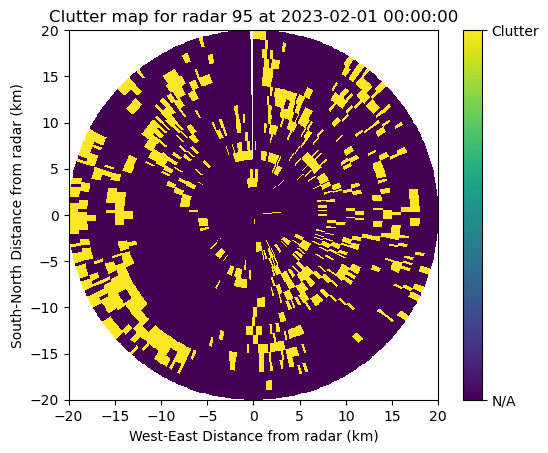

In [8]:
azi = np.arange(0, 360)
theta = np.deg2rad((450 - azi) % 360)
r = np.arange(0, 21)
R, T = np.meshgrid(r, theta)
x = R * np.cos(T)
y = R * np.sin(T)

fig = plt.figure()
plt.pcolormesh(x, y, cmask)
plt.gca().set_aspect(1)
cbar = plt.colorbar()
cbar.set_ticks([0, 1])
cbar.set_ticklabels(["N/A", "Clutter"])
plt.title(f"Clutter map for radar {rid} at {date}")
plt.xlabel("West-East Distance from radar (km)")
plt.ylabel("South-North Distance from radar (km)")
plt.show()

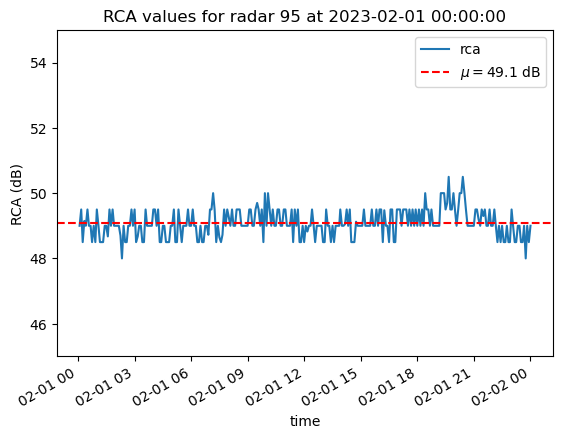

In [9]:
df.plot()
plt.axhline(df.rca.mean(), color="r", linestyle="--", label=f"$\\mu=${df.rca.mean():.1f} dB")
plt.legend()
plt.ylim(45, 55)
plt.ylabel("RCA (dB)")
plt.title(f"RCA values for radar {rid} at {date}")
plt.show()